In [14]:
import networkx as nx
import random
import seaborn as sns
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def simulate(
        G: nx.Graph,
        initial_susceptible: int,
        num_iter: int,
        beta: float,
        gamma: float,
):
    nodes = list(G.nodes())
    infected = set(random.sample(nodes, G.number_of_nodes() - initial_susceptible))
    
    infected_over_time = [len(infected)]

    for i in range(num_iter):
        fresh_infected = set()
        fresh_recovered = set()

        for v in infected:
            if random.random() < gamma:
                fresh_recovered.add(v)
            
            for neigh in G.neighbors(v):
                if neigh not in infected and random.random() < beta:
                    fresh_infected.add(neigh)

        infected = (infected - fresh_recovered) | fresh_infected
        infected_over_time.append(len(infected))

    return infected_over_time

# P11.1

In [4]:
N = 1000
p = 0.01
initial_susceptible = 950
gamma = 0.05
betas = np.linspace(0, 0.6, 50)
num_iter = 500

G = nx.erdos_renyi_graph(N, p)

In [5]:
results_sim = []
results_theory = []
k_avg = sum(dict(G.degree()).values()) / N
s_0 = initial_susceptible / N

for beta in tqdm(betas):
    i_hist = simulate(G, initial_susceptible, num_iter, beta, gamma)
    i_steady_sim = np.mean(i_hist[-100:]) / N # Ratio of infected [cite: 142]
    results_sim.append(i_steady_sim)

    if beta > 0 and (beta/gamma) > (1 / (k_avg * s_0)):
        i_steady_theory = 1 - (gamma / (beta * k_avg))
    else:
        i_steady_theory = 0
    results_theory.append(max(0, i_steady_theory))

100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


<Axes: >

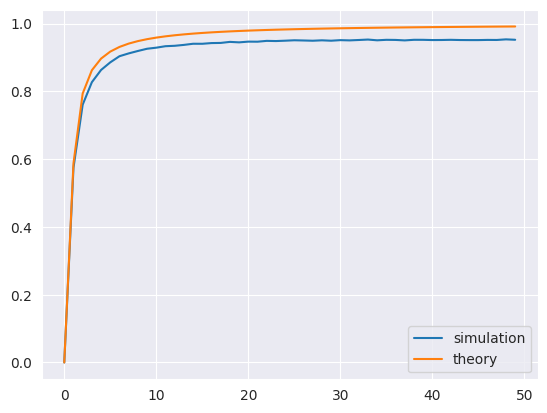

In [6]:
sns.lineplot(results_sim, label='simulation')
sns.lineplot(results_theory, label='theory')

In [7]:
nx.number_connected_components(G)

1

# P11.2

In [8]:
N = 1000 
m = 4
G_ba = nx.barabasi_albert_graph(N, m)

In [9]:
degrees = [d for n, d in G_ba.degree()]
k_avg = np.mean(degrees)
k2_avg = np.mean([d**2 for d in degrees])

In [10]:
results_sim_ba = []
results_theory_ba = []

degrees = [d for n, d in G_ba.degree()]
k_avg = np.mean(degrees) # <k> 
k2_avg = np.mean([d**2 for d in degrees]) # <k^2> 
s_0 = initial_susceptible / N # s(0) 

# Theoretical epidemic threshold for BA 
lambda_c_ba = k_avg / k2_avg 

for beta in tqdm(betas):
    i_hist = simulate(G_ba, initial_susceptible, num_iter, beta, gamma)
    
    if i_hist[-1] > 0:
        i_steady_sim = np.mean(i_hist[-100:]) / N
    else:
        i_steady_sim = 0
    results_sim_ba.append(i_steady_sim)
    
    # Current spreading rate
    lam = beta / gamma
    
    if lam > lambda_c_ba:
        i_steady_theory = 1 - (gamma / (beta * k_avg))
    else:
        i_steady_theory = 0
    results_theory_ba.append(max(0, i_steady_theory))

100%|██████████| 50/50 [00:13<00:00,  3.84it/s]


<Axes: >

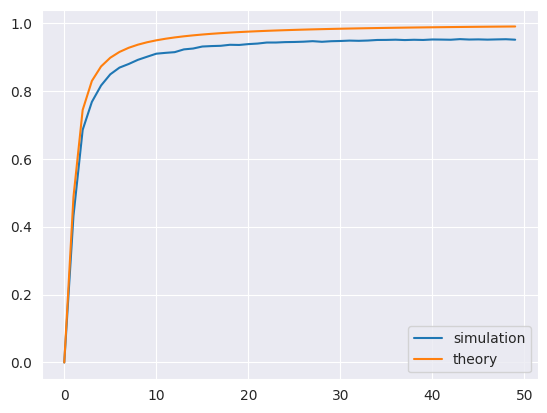

In [11]:
sns.lineplot(results_sim_ba, label='simulation')
sns.lineplot(results_theory_ba, label='theory')

# P11.3

In [12]:
def simulate_sir(G, initial_infected_count, num_iter, beta, gamma):
    nodes = list(G.nodes())
    infected = set(random.sample(nodes, initial_infected_count))
    recovered = set()

    s_hist, i_hist, r_hist = [], [], []

    for _ in range(num_iter):
        new_infected = set()
        new_recovered = set()

        # Process recoveries
        for v in infected:
            if random.random() < gamma:
                new_recovered.add(v)

            # Process new infections
            for neigh in G.neighbors(v):
                # Infect if Susceptible
                if neigh not in infected and neigh not in recovered and random.random() < beta:
                    new_infected.add(neigh)

        infected = (infected - new_recovered) | new_infected
        recovered |= new_recovered

        i_hist.append(len(infected))
        r_hist.append(len(recovered))
        s_hist.append(G.number_of_nodes() - len(infected) - len(recovered))

    return s_hist, i_hist, r_hist

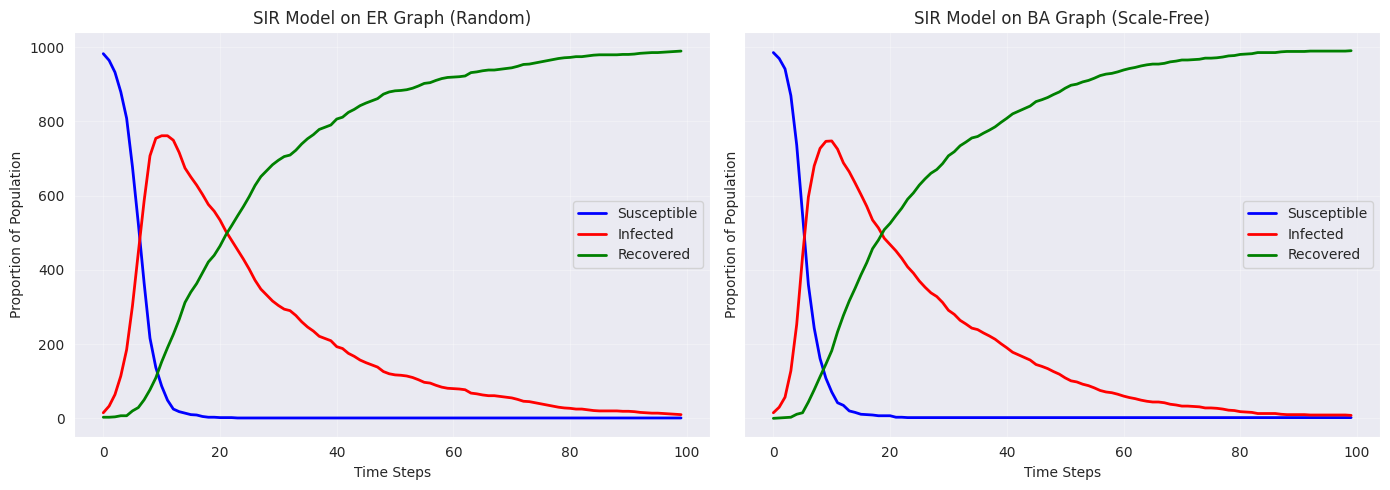

In [18]:
N = 1000
num_iter = 100
beta = 0.1
gamma = 0.05
initial_infected = 10

# Generate Graphs
G_er = nx.erdos_renyi_graph(N, 0.01) # Average degree k ~ 10
G_ba = nx.barabasi_albert_graph(N, 5) # Average degree k ~ 10

# Run Simulations
results_er = simulate_sir(G_er, initial_infected, num_iter, beta, gamma)
results_ba = simulate_sir(G_ba, initial_infected, num_iter, beta, gamma)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, res, title in zip(axes, [results_er, results_ba], ["ER Graph (Random)", "BA Graph (Scale-Free)"]):
    s, i, r = res
    ax.plot(s, label='Susceptible', color='blue', lw=2)
    ax.plot(i, label='Infected', color='red', lw=2)
    ax.plot(r, label='Recovered', color='green', lw=2)
    ax.set_title(f"SIR Model on {title}")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Proportion of Population")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()